# Исследование технологического процесса очистки золота

### Описание проекта
Подготовим прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используем данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Импортируем требуемые для анализа библиотеки:

In [1]:
#importing all the libraries needed
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import warnings
#warnings.filterwarnings('ignore')

from IPython.display import display
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    mean_absolute_error, make_scorer
)
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import  LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyClassifier

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

#np.random.seed(0)
RANDOM_STATE = 42
CV = 3

## Подготовка данных

### Загрузка данных. Изучим предоставленные датасеты

In [2]:
def data_read(df_name):
    try:
        data = pd.read_csv(f'C:\\Users\\m5612\\Downloads\\gold_recovery_{df_name}_new.csv', 
        index_col='date', parse_dates=True)
    except:
        data = pd.read_csv(f'/datasets/gold_recovery_{df_name}_new.csv', 
        index_col='date', parse_dates=True)
    return data

In [3]:
df_full = data_read('full')
df_train = data_read('train')
df_test = data_read('test')

Посмотрим как разбита полная выборка на train и test:

In [4]:
df_full.shape[0] == df_train.shape[0] + df_test.shape[0]

True

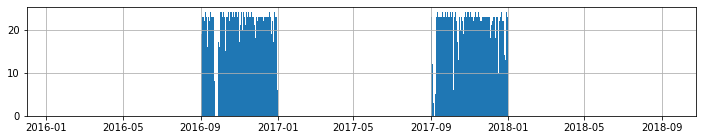

In [5]:
pd.Series(df_test.index).hist(bins=500, figsize=(12,2))
plt.xlim(16770, 17830);

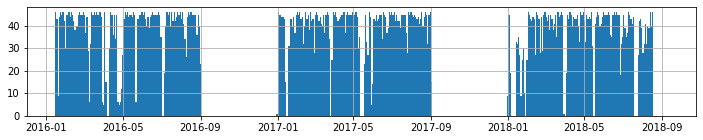

In [6]:
pd.Series(df_train.index).hist(bins=500, figsize=(12,2))
plt.xlim(16770, 17830);

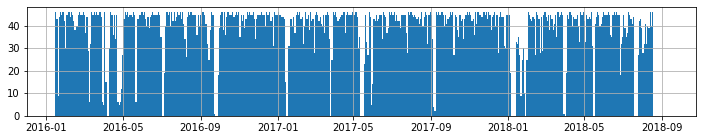

In [7]:
pd.Series(df_full.index).hist(bins=500, figsize=(12,2))
plt.xlim(16770, 17830);

Обзор данных

In [8]:
def get_data_info(data):
    print('Датафрейм:')    
    display(data.head(5).T)
    print('\nИнфо:')
    data.info()
    display(data.describe(include='all').T)

In [9]:
get_data_info(df_full)

Датафрейм:


date,2016-01-15 00:00:00,2016-01-15 01:00:00,2016-01-15 02:00:00,2016-01-15 03:00:00,2016-01-15 04:00:00
final.output.concentrate_ag,6.055403,6.029369,6.055926,6.047977,6.148599
final.output.concentrate_pb,9.889648,9.968944,10.213995,9.977019,10.142511
final.output.concentrate_sol,5.507324,5.257781,5.383759,4.858634,4.939416
final.output.concentrate_au,42.192020,42.701629,42.657501,42.689819,42.774141
final.output.recovery,70.541216,69.266198,68.116445,68.347543,66.927016
final.output.tail_ag,10.411962,10.462676,10.507046,10.422762,10.360302
final.output.tail_pb,0.895447,0.927452,0.953716,0.883763,0.792826
final.output.tail_sol,16.904297,16.634514,16.208849,16.532835,16.525686
final.output.tail_au,2.143149,2.224930,2.257889,2.146849,2.055292
primary_cleaner.input.sulfate,127.092003,125.629232,123.819808,122.270188,117.988169



Инфо:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au              

,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,19438.0,5.168470,1.372348,0.000000e+00,4.251240,5.066094,5.895527,1.600195e+01
final.output.concentrate_pb,19438.0,9.978895,1.669240,0.000000e+00,9.137262,10.102433,11.035769,1.703190e+01
final.output.concentrate_sol,19228.0,9.501224,2.787537,0.000000e+00,7.722820,9.218961,10.947813,1.961572e+01
final.output.concentrate_au,19439.0,44.076513,5.129784,0.000000e+00,43.402215,45.011244,46.275313,5.275664e+01
final.output.recovery,19439.0,67.050208,10.125840,0.000000e+00,63.299712,68.172738,72.686642,1.000000e+02
final.output.tail_ag,19438.0,9.688589,2.328642,0.000000e+00,8.062878,9.743623,11.134294,1.955215e+01
final.output.tail_pb,19338.0,2.705795,0.949077,0.000000e+00,2.040119,2.748730,3.333216,5.804178e+00
final.output.tail_sol,19433.0,10.583728,2.868782,0.000000e+00,8.938947,10.622456,12.104271,2.231773e+01
final.output.tail_au,19439.0,3.042467,0.922808,0.000000e+00,2.461138,2.984909,3.571351,8.245022e+00
primary_cleaner.input.sulfate,19415.0,144.624774,44.464071,3.111820e-03,114.107029,143.232103,175.075656,2.659831e+02


In [10]:
get_data_info(df_test)

Датафрейм:


date,2016-09-01 00:59:59,2016-09-01 01:59:59,2016-09-01 02:59:59,2016-09-01 03:59:59,2016-09-01 04:59:59
primary_cleaner.input.sulfate,210.800909,215.392455,215.259946,215.336236,199.099327
primary_cleaner.input.depressant,14.993118,14.987471,12.884934,12.006805,10.682530
primary_cleaner.input.feed_size,8.080000,8.080000,7.786667,7.640000,7.530000
primary_cleaner.input.xanthate,1.005021,0.990469,0.996043,0.863514,0.805575
primary_cleaner.state.floatbank8_a_air,1398.981301,1398.777912,1398.493666,1399.618111,1401.268123
primary_cleaner.state.floatbank8_a_level,-500.225577,-500.057435,-500.868360,-498.863574,-500.808305
primary_cleaner.state.floatbank8_b_air,1399.144926,1398.055362,1398.860436,1397.440120,1398.128818
primary_cleaner.state.floatbank8_b_level,-499.919735,-499.778182,-499.764529,-499.211024,-499.504543
primary_cleaner.state.floatbank8_c_air,1400.102998,1396.151033,1398.075709,1400.129303,1402.172226
primary_cleaner.state.floatbank8_c_level,-500.704369,-499.240168,-502.151509,-498.355873,-500.810606



Инфо:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level  

,count,mean,std,min,25%,50%,75%,max
primary_cleaner.input.sulfate,5286.0,174.839652,43.027080,2.566156e+00,147.121401,177.828489,208.125438,265.983123
primary_cleaner.input.depressant,5285.0,8.683596,3.072050,3.839482e-03,6.489555,8.052207,10.027764,40.000000
primary_cleaner.input.feed_size,5290.0,7.266339,0.610219,5.650000e+00,6.890000,7.250000,7.600000,15.500000
primary_cleaner.input.xanthate,5286.0,1.383803,0.643474,4.983673e-03,0.907623,1.197610,1.797819,4.102454
primary_cleaner.state.floatbank8_a_air,5290.0,1539.494325,116.797884,5.445860e-32,1498.935802,1585.129123,1602.076529,2103.103580
primary_cleaner.state.floatbank8_a_level,5290.0,-497.665883,19.952431,-7.953163e+02,-500.357298,-499.969164,-499.568951,-57.195404
primary_cleaner.state.floatbank8_b_air,5290.0,1545.174232,122.224588,6.647490e-32,1498.970993,1595.621798,1602.323545,1813.083671
primary_cleaner.state.floatbank8_b_level,5290.0,-500.273098,32.968307,-7.999970e+02,-500.703002,-500.028514,-499.293257,-142.527229
primary_cleaner.state.floatbank8_c_air,5290.0,1527.272362,122.538034,4.033736e-32,1473.229862,1549.594682,1601.143775,1715.053773
primary_cleaner.state.floatbank8_c_level,5290.0,-498.330680,21.964876,-7.999606e+02,-501.018117,-500.017711,-498.994130,-150.937035


In [11]:
get_data_info(df_train)

Датафрейм:


date,2016-01-15 00:00:00,2016-01-15 01:00:00,2016-01-15 02:00:00,2016-01-15 03:00:00,2016-01-15 04:00:00
final.output.concentrate_ag,6.055403,6.029369,6.055926,6.047977,6.148599
final.output.concentrate_pb,9.889648,9.968944,10.213995,9.977019,10.142511
final.output.concentrate_sol,5.507324,5.257781,5.383759,4.858634,4.939416
final.output.concentrate_au,42.192020,42.701629,42.657501,42.689819,42.774141
final.output.recovery,70.541216,69.266198,68.116445,68.347543,66.927016
final.output.tail_ag,10.411962,10.462676,10.507046,10.422762,10.360302
final.output.tail_pb,0.895447,0.927452,0.953716,0.883763,0.792826
final.output.tail_sol,16.904297,16.634514,16.208849,16.532835,16.525686
final.output.tail_au,2.143149,2.224930,2.257889,2.146849,2.055292
primary_cleaner.input.sulfate,127.092003,125.629232,123.819808,122.270188,117.988169



Инфо:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au              

,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,14148.0,5.142034,1.369586,0.000000e+00,4.211620,4.994652,5.859540,1.600195e+01
final.output.concentrate_pb,14148.0,10.132960,1.654930,0.000000e+00,9.297355,10.297144,11.170603,1.703190e+01
final.output.concentrate_sol,13938.0,9.202849,2.790516,0.000000e+00,7.484645,8.845462,10.487508,1.812485e+01
final.output.concentrate_au,14149.0,44.003792,4.905261,0.000000e+00,43.276111,44.872436,46.166425,5.275664e+01
final.output.recovery,14149.0,66.518832,10.295402,0.000000e+00,62.545817,67.432775,72.346428,1.000000e+02
final.output.tail_ag,14149.0,9.607035,2.319069,0.000000e+00,7.997429,9.480270,11.003707,1.955215e+01
final.output.tail_pb,14049.0,2.597298,0.971843,0.000000e+00,1.905973,2.592022,3.241723,5.639565e+00
final.output.tail_sol,14144.0,10.512122,3.003617,0.000000e+00,8.811324,10.514621,11.933009,2.231773e+01
final.output.tail_au,14149.0,2.918421,0.903712,0.000000e+00,2.368607,2.851025,3.434764,8.197408e+00
primary_cleaner.input.sulfate,14129.0,133.320659,39.431659,3.111820e-03,107.006651,133.018328,159.825396,2.501278e+02


### Проверим расчет эффективности обогащения

In [12]:
c = df_train['rougher.output.concentrate_au']

In [13]:
f = df_train['rougher.input.feed_au']

In [14]:
t = df_train['rougher.output.tail_au']

In [15]:
rec = (c * (f - t)) / (f * (c - t)) * 100

In [16]:
mean_absolute_error(rec, df_train['rougher.output.recovery'])

9.73512347450521e-15

#### Выводы:  
Среднее абсолютное отклонение очень маленькое, мы подтвердили правильность расчета эффективности обогащения в предоставленных данных.

### Анализ признаков, недоступных в тестовой выборке

In [17]:
columns_not_test = set([*df_train.columns]) - set([*df_test.columns]) \
- set(['final.output.recovery', 'rougher.output.recovery'])
columns_not_test

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'secondary_cleane

В тестовой выборке отсутствуют полностью этап `final`, а также все признаки с типами параметров `output` и `calculation`.

### Предобработка данных

Посмотрим пропуски

In [18]:
na_train = (df_train.isna().mean().sort_values(ascending=False) * 100).round(2)
na_train[na_train > 0]

secondary_cleaner.output.tail_sol                     11.34
rougher.state.floatbank10_e_air                        3.08
rougher.input.floatbank11_xanthate                     3.02
primary_cleaner.output.concentrate_sol                 2.02
secondary_cleaner.state.floatbank2_a_air               1.53
final.output.concentrate_sol                           1.49
rougher.input.feed_size                                1.02
rougher.input.feed_pb                                  0.71
final.output.tail_pb                                   0.71
primary_cleaner.input.xanthate                         0.71
primary_cleaner.output.concentrate_pb                  0.61
rougher.input.feed_sol                                 0.55
primary_cleaner.output.tail_sol                        0.33
rougher.input.floatbank11_sulfate                      0.25
primary_cleaner.input.depressant                       0.23
rougher.input.floatbank10_sulfate                      0.20
rougher.output.concentrate_sol          

In [19]:
na_test = (df_test.isna().mean().sort_values(ascending=False) * 100).round(2)
na_test[na_test > 0]

rougher.input.floatbank11_xanthate          0.47
rougher.input.feed_sol                      0.40
secondary_cleaner.state.floatbank3_a_air    0.17
rougher.input.floatbank11_sulfate           0.15
primary_cleaner.input.depressant            0.09
rougher.input.floatbank10_sulfate           0.09
primary_cleaner.input.sulfate               0.08
primary_cleaner.input.xanthate              0.08
rougher.input.feed_rate                     0.06
secondary_cleaner.state.floatbank2_a_air    0.06
secondary_cleaner.state.floatbank2_b_air    0.04
rougher.input.feed_size                     0.02
dtype: float64

Заполним пропуски методом `interpolate`

In [20]:
df_train.interpolate(inplace=True)
df_test.interpolate(inplace=True)

Добавим целевые признаки в тестовую выборку

In [23]:
df_test = df_test.join(df_full[['rougher.output.recovery', 'final.output.recovery']])

### Выводы:

- Заполнили пропуски  методом `interpolate`
- Удалили из обучающей выборки признаки которых нет в тестовой выборке
- Удалили пустые строки в обучающей и тестовой выборках
- В тестовой и обучающей выборках имеем одинаковое количество признаков. Размер тестовой 5383 строк, размер обучающей 1680 строк.
- Можно приступать к анализу и машинному обучению

## Анализ данных

### Анализ концентрации металлов (Au, Ag, Pb) на различных этапах очистки

In [25]:
dict_stage = dict(raw_material=['rougher.input.feed_ag',
                               'rougher.input.feed_pb',
                               'rougher.input.feed_au',
                               'rougher.input.feed_sol'],
rougher=['rougher.output.concentrate_ag', 
               'rougher.output.concentrate_pb', 
               'rougher.output.concentrate_au', 
               'rougher.output.concentrate_sol'],
primary_cleaner=['primary_cleaner.output.concentrate_ag', 
                       'primary_cleaner.output.concentrate_pb', 
                       'primary_cleaner.output.concentrate_au', 
                       'primary_cleaner.output.concentrate_sol'],
final=['final.output.concentrate_ag', 
             'final.output.concentrate_pb', 
             'final.output.concentrate_au', 
             'final.output.concentrate_sol'])

In [26]:
substances = ['ag', 'pb', 'au', 'sol']

In [27]:
df_substances = pd.DataFrame(data = dict_stage.values(), columns=substances)
df_substances.insert(0, 'stage', list(dict_stage.keys()))
df_substances

,stage,ag,pb,au,sol
0,raw_material,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_au,rougher.input.feed_sol
1,rougher,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_au,rougher.output.concentrate_sol
2,primary_cleaner,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_sol
3,final,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_au,final.output.concentrate_sol


In [28]:
def concentration_substances(substances):
    fig = plt.figure(figsize=(12, 5))
    ax = plt.subplot(111)
    for i in range(len(df_substances)): 
        ax.hist(df_train[df_substances.loc[i, substances]], 
                bins=100, 
                alpha= 0.5,
                density=True,
                label=f'{df_substances.loc[i, "stage"]}, \
    mean = {df_train[df_substances.loc[i, substances]].mean():.1f}')

    ax.legend(title = 'stages')
    plt.xlabel('substance concentration, %')
    plt.ylabel('proportion of measurements')
    plt.title(substances, fontsize = 16)
    plt.grid()
    plt.show()

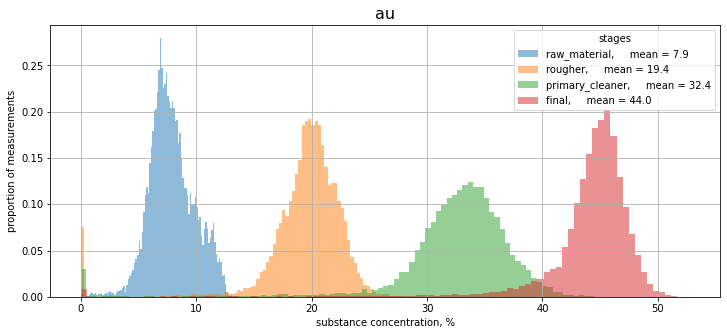

In [29]:
concentration_substances('au')

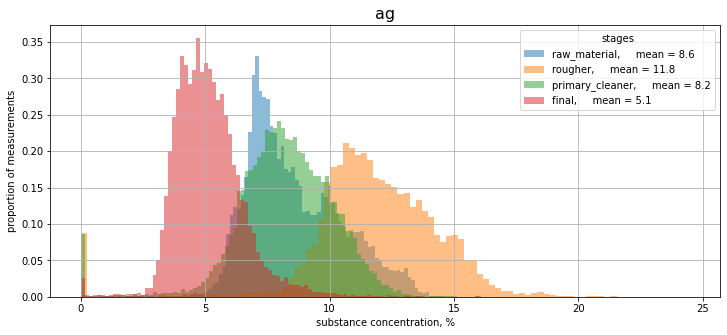

In [30]:
concentration_substances('ag')

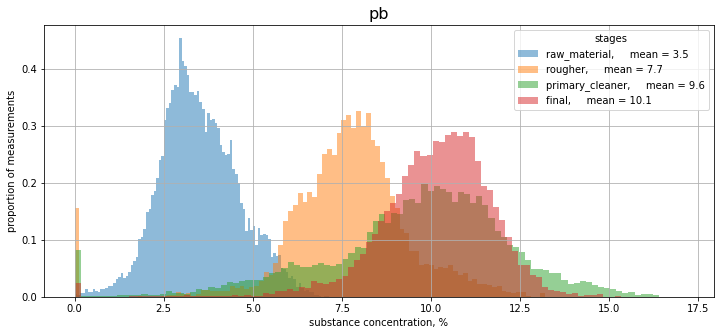

In [31]:
concentration_substances('pb')

#### Выводы:

Содержание золота, как и ожидалось, повышается плавно на каждом этапе.
Содержание серебра после флотации увеличивается, на следующих этапах падает.
Содержание свинца увеличивается на первых двух этапах, а на финальной стадии заметно уменьшается разброс значений. Около нуля присутствуют выбросы.

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

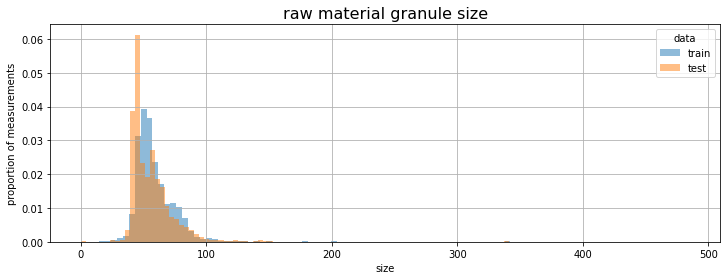

In [32]:
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(111)
ax.hist(df_train['rougher.input.feed_size'], 
        density=True, 
        bins=100, 
        alpha= 0.5, 
        label='train')
ax.hist(df_test['rougher.input.feed_size'], 
        density=True, 
        bins=100, 
        alpha= 0.5, 
        label='test')
ax.legend(title = 'data')
plt.xlabel('size')
plt.ylabel('proportion of measurements')
plt.title('raw material granule size', fontsize = 16)
plt.grid()
plt.show()

#### Выводы

Размер гранул имеет схожее распределение.

### Исследование суммарной концентрации всех веществ на разных стадиях

In [33]:
def total_concentration(df, xlim=101):
    fig = plt.figure(figsize=(12, 4))
    ax = plt.subplot(111)
    for i in range(len(df_substances)):
        ax.hist(df[df_substances.loc[i, 'ag']] +
                df[df_substances.loc[i, 'pb']] +
                df[df_substances.loc[i, 'au']] +
                df[df_substances.loc[i, 'sol']],
                bins=200,
                alpha= 0.5,
                label=df_substances.loc[i, 'stage'],
                density=True)

    ax.set_xlim([-1, xlim])
    ax.legend(title = 'stages')
    plt.xlabel('concentration, %')
    plt.ylabel('proportion of measurements')
    plt.title('the total concentration of all substances at different stages', 
              fontsize = 16)
    plt.grid()
    plt.show()

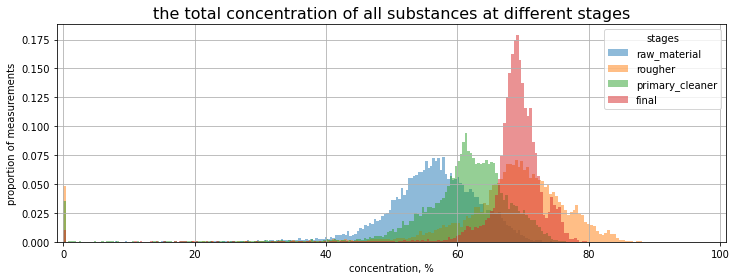

In [34]:
total_concentration(df_train)

#### Выводы:

Мы наблюдаем повышение концентрации после флотации, на следующей стадии небольшой откат и снова повышение со значительным уменьшением разброса. Сильных изменений нет. Аномалии около нуля являются следствием какого-то сбоя, удалим их.

### Удаление аномалий

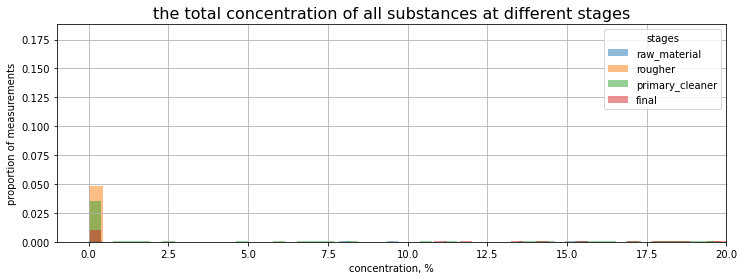

In [35]:
total_concentration(df_train, 20)

In [36]:
df_train.shape

(14149, 86)

In [37]:
for i in range(len(df_substances)):
    df_train.drop(df_train[df_train.loc[:, df_substances.loc[i, 'au']]<1.].index,inplace=True, axis=0)

In [38]:
df_train.shape

(13593, 86)

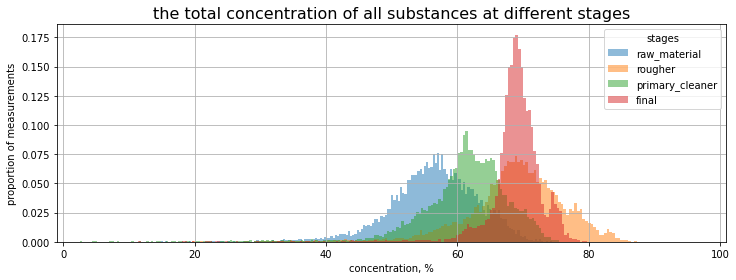

In [39]:
total_concentration(df_train)

Аномальные строки удалены

Удалим признаки отсутствующие в тестовой выборке

In [40]:
df_train = df_train.drop(columns=list(columns_not_test))

In [41]:
df_train.shape

(13593, 54)

### Анализ корреляций

In [42]:
df_train.corr()

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
final.output.recovery,1.000000,0.388450,0.154715,0.062541,0.229282,0.165166,0.048544,0.182819,0.041844,0.170743,0.046117,0.072405,-0.038070,0.343505,0.219590,0.165958,0.050618,0.285693,0.335483,-0.022628,0.340156,0.000485,0.283584,0.611050,0.252684,0.102337,-0.156593,-0.086430,-0.197709,-0.096925,-0.189146,-0.096398,-0.129782,-0.097879,-0.098151,-0.095950,0.159233,-0.012119,0.143158,-0.018905,0.217596,0.030261,0.049875,-0.000195,0.232985,0.056703,0.193182,-0.109614,0.117269,0.029650,0.086545,0.046800,-0.015122,-0.051589
primary_cleaner.input.sulfate,0.388450,1.000000,0.484057,0.158198,0.266152,0.031174,-0.046850,0.054607,-0.042704,0.051724,-0.038164,0.116887,-0.038435,0.549840,0.570438,0.301232,-0.075236,0.381044,0.614263,0.392490,0.368576,0.503629,0.411910,0.430999,0.206306,0.084809,-0.237224,-0.234698,-0.265377,-0.236938,-0.302083,-0.235550,-0.269516,-0.241545,-0.248402,-0.241875,0.128025,0.103364,0.131366,0.121898,0.083172,-0.024535,0.000225,-0.054332,0.086356,0.023617,0.106712,-0.061487,-0.004041,-0.040609,0.005268,-0.035329,-0.109257,-0.153229
primary_cleaner.input.depressant,0.154715,0.484057,1.000000,0.168457,0.277779,-0.148823,0.121358,-0.109207,0.137233,-0.122271,0.139672,-0.093969,0.057470,0.479762,0.279849,0.151785,-0.068708,0.084351,0.421768,0.134128,0.371592,0.250865,0.421395,0.123802,-0.035058,-0.269328,-0.116666,-0.328034,-0.148793,-0.325919,-0.134080,-0.325836,-0.037329,-0.332305,-0.068265,-0.335464,-0.055912,0.189212,0.080207,0.178075,-0.170446,-0.082861,0.020291,0.006886,-0.234664,-0.165185,-0.132297,-0.287780,-0.261267,-0.164373,-0.217531,-0.156722,-0.166943,-0.131543
primary_cleaner.input.feed_size,0.062541,0.158198,0.168457,1.000000,-0.004951,-0.128733,0.080224,-0.128230,0.083314,-0.153788,0.080839,-0.197006,0.074819,0.110722,-0.099119,0.084149,-0.150714,0.067874,0.121574,0.094334,0.011690,0.153499,0.056226,-0.056437,-0.219360,-0.356863,0.181989,0.073173,0.191588,0.063684,0.195625,0.060863,0.149244,0.059089,0.134970,0.058830,-0.175430,0.108407,-0.135274,0.087046,-0.156751,0.095087,0.013673,0.134490,-0.329693,0.110909,-0.252

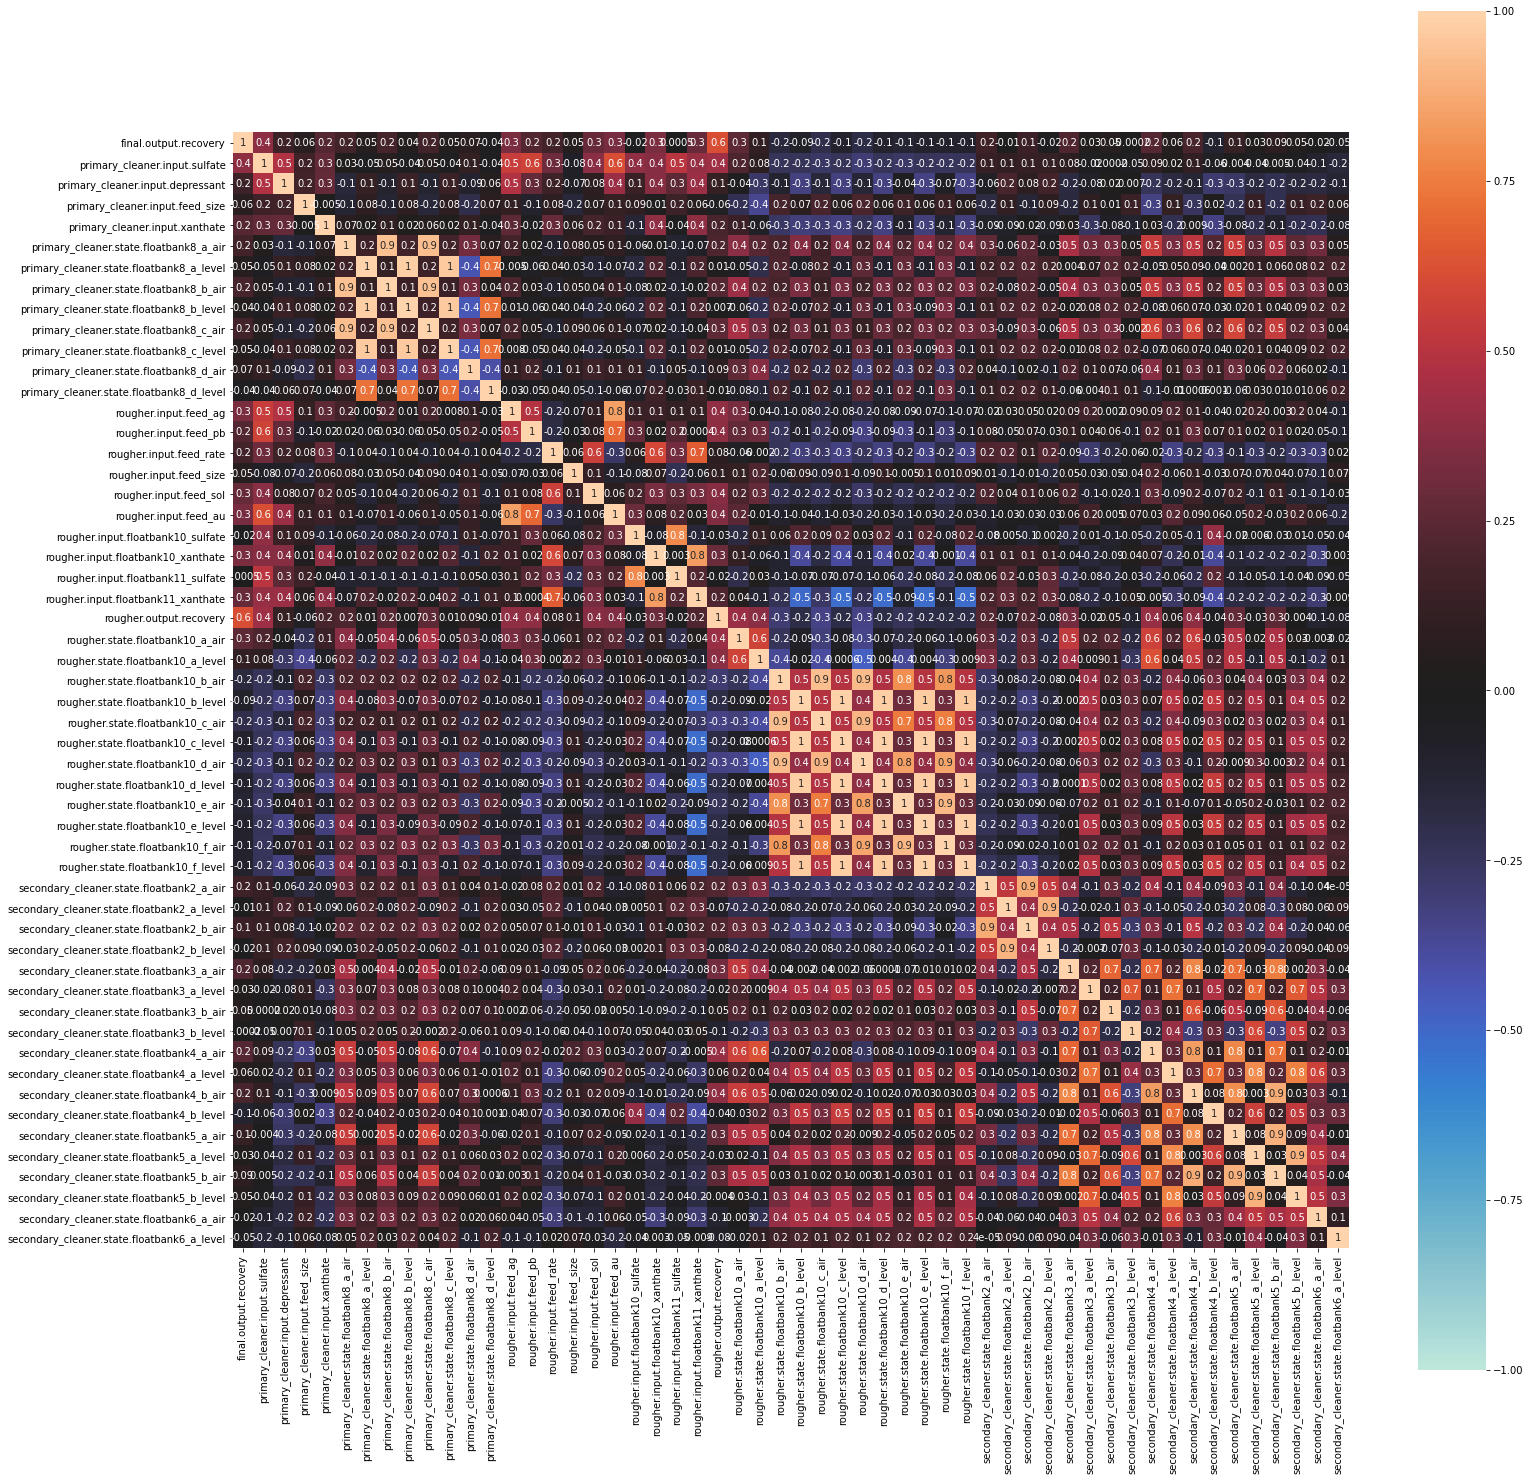

In [43]:
plt.figure(figsize = (25,25))
ax = sns.heatmap(df_train.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0,square=True)

Удалим коррелирующие столбцы

In [44]:
df_train.shape

(13593, 54)

In [45]:
df_train.drop(columns=['primary_cleaner.state.floatbank8_b_level', 
                    'primary_cleaner.state.floatbank8_c_level', 
                    'rougher.state.floatbank10_c_level', 
                    'rougher.state.floatbank10_d_level', 
                    'rougher.state.floatbank10_e_level', 
                    'rougher.state.floatbank10_f_level'],
           inplace=True)

In [46]:
df_test.drop(columns=['primary_cleaner.state.floatbank8_b_level', 
                    'primary_cleaner.state.floatbank8_c_level', 
                    'rougher.state.floatbank10_c_level', 
                    'rougher.state.floatbank10_d_level', 
                    'rougher.state.floatbank10_e_level', 
                    'rougher.state.floatbank10_f_level'],
           inplace=True)

In [47]:
df_train.shape

(13593, 48)

### Выводы:

удалили столбцы с сильной корреляцией.

## Функция для вычисления итоговой sMAPE

In [48]:
def smape_calc(y_true, y_pred):
    return (1 / len(y_true)) * (np.sum(np.abs(y_true - y_pred) / 
                                        ((np.abs(y_true) + np.abs(y_pred)) / 2))) * 100

def total_smape(best_score_rougher, best_score_final):
    return best_score_rougher * .25 + best_score_final * .75


smape_score = make_scorer(smape_calc, greater_is_better=False)

## Построение модели

#### Выделим целевые признаки

In [49]:
X_train_final = df_train.drop(columns=["rougher.output.recovery", "final.output.recovery"])
X_train_rougher = X_train_final[[x for x in X_train_final.columns if 'rougher' in x]]
y_train_rougher = df_train["rougher.output.recovery"]
y_train_final = df_train["final.output.recovery"]

X_test_final = df_test.drop(columns=["rougher.output.recovery", "final.output.recovery"])
X_test_rougher = X_test_final[[x for x in X_test_final.columns if 'rougher' in x]]
y_test_rougher = df_test["rougher.output.recovery"]
y_test_final = df_test["final.output.recovery"]

In [50]:
print(X_train_final.shape, X_train_rougher.shape, y_train_rougher.shape, y_train_final.shape)
print(X_test_final.shape, X_test_rougher.shape, y_test_rougher.shape, y_test_final.shape)

(13593, 46) (13593, 18) (13593,) (13593,)
(5290, 46) (5290, 18) (5290,) (5290,)


### Дерево решений

In [51]:
%%time
dtr = DecisionTreeRegressor(random_state = RANDOM_STATE)
param_grid = {'max_depth': range(2, 25)}

grid_dtr_rougher = GridSearchCV(dtr, param_grid, scoring=smape_score, n_jobs=-1, cv=CV)
grid_dtr_rougher.fit(X_train_rougher, y_train_rougher)
dtr_best_score_rougher = abs(grid_dtr_rougher.best_score_)
print (dtr_best_score_rougher)
print (grid_dtr_rougher.best_params_)

8.610486419736441
{'max_depth': 2}
CPU times: user 11.3 s, sys: 6.9 ms, total: 11.4 s
Wall time: 11.4 s


In [52]:
%%time
dtr = DecisionTreeRegressor(random_state = RANDOM_STATE)
param_grid = {'max_depth': range(2, 25)}

grid_dtr_final = GridSearchCV(dtr, param_grid, scoring=smape_score, n_jobs=-1, cv=CV)
grid_dtr_final.fit(X_train_final, y_train_final)
dtr_best_score_final = abs(grid_dtr_final.best_score_)
print (dtr_best_score_final)
print (grid_dtr_final.best_params_)

10.82466716419234
{'max_depth': 3}
CPU times: user 27.8 s, sys: 72.6 ms, total: 27.9 s
Wall time: 28.1 s


In [53]:
dtr_best_score = total_smape(dtr_best_score_rougher, dtr_best_score_final)
dtr_best_score

10.271121978078364

### Случайный лес

In [54]:
%%time
rfr = RandomForestRegressor(random_state = RANDOM_STATE)
param_grid = { 'max_depth': range (2,15),
              'n_estimators': [5, 10, 15, 20, 40, 80]}

grid_rfr_rougher = GridSearchCV(rfr, param_grid, scoring=smape_score, n_jobs=-1, cv=CV)
grid_rfr_rougher.fit(X_train_rougher, y_train_rougher)
rfr_best_score_rougher = abs(grid_rfr_rougher.best_score_)
print (rfr_best_score_rougher)
print (grid_rfr_rougher.best_params_)

7.796865011591855
{'max_depth': 6, 'n_estimators': 80}
CPU times: user 7min 49s, sys: 1.08 s, total: 7min 50s
Wall time: 7min 52s


In [55]:
%%time
dtr = DecisionTreeRegressor(random_state = RANDOM_STATE)
param_grid = { 'max_depth': range (2,15),
              'n_estimators': [5, 10, 15, 20, 40, 80]}

grid_rfr_final = GridSearchCV(rfr, param_grid, scoring=smape_score, n_jobs=-1, cv=CV)
grid_rfr_final.fit(X_train_final, y_train_final)
rfr_best_score_final = abs(grid_rfr_final.best_score_)
print (rfr_best_score_final)
print (grid_rfr_final.best_params_)

10.006529151112966
{'max_depth': 2, 'n_estimators': 80}
CPU times: user 19min 3s, sys: 2.16 s, total: 19min 5s
Wall time: 19min 6s


In [56]:
rfr_best_score = total_smape(rfr_best_score_rougher, rfr_best_score_final)
rfr_best_score

9.454113116232689

### Линейная регрессия

In [57]:
%%time
lr = LinearRegression()
param_grid = {}

grid_lr_rougher = GridSearchCV(lr, param_grid, scoring=smape_score, n_jobs=-1, cv=CV)
grid_lr_rougher.fit(X_train_rougher, y_train_rougher)
lr_best_score_rougher = abs(grid_lr_rougher.best_score_)
print (lr_best_score_rougher)
print (grid_lr_rougher.best_params_)

8.687790717990044
{}
CPU times: user 92.5 ms, sys: 335 ms, total: 428 ms
Wall time: 428 ms


In [58]:
%%time
lr = LinearRegression()
param_grid = {}

grid_lr_final = GridSearchCV(lr, param_grid, scoring=smape_score, n_jobs=-1, cv=CV)
grid_lr_final.fit(X_train_final, y_train_final)
lr_best_score_final = abs(grid_lr_final.best_score_)
print (lr_best_score_final)
print (grid_lr_final.best_params_)

13.370108374682841
{}
CPU times: user 379 ms, sys: 918 ms, total: 1.3 s
Wall time: 1.3 s


In [59]:
lr_best_score = total_smape(lr_best_score_rougher, lr_best_score_final)
lr_best_score

12.199528960509642

### Выводы

Лучшая модель на тренировочной выборке - Случайный лес. Итоговое sMAPE на ней равно 9.45.

## Проверка на тестовой выборке

In [65]:
smape_rfr_rougher = smape_calc(y_test_rougher, grid_rfr_rougher.predict(X_test_rougher))
smape_rfr_rougher

8.237507647785508

In [66]:
smape_rfr_final = smape_calc(y_test_final, grid_rfr_final.predict(X_test_final))
smape_rfr_final

9.308720733981007

In [68]:
test_total_smape = total_smape(smape_rfr_rougher, smape_rfr_final)
test_total_smape

9.040917462432132

### Сравнение с константной моделью

In [63]:
constant_smape = total_smape(smape_calc(y_test_rougher, y_test_rougher.median()),
                             smape_calc(y_test_final, y_test_final.median()))

In [64]:
constant_smape

8.889496773146032

#### Выводы

В результате обучения и тестирования моделей лучший показатель sMAPE равный 9.05 был получен у случайного леса. Константная модель показала лучшие результаты (8.89). 

Целевого показателя в условиях задачи нет и в дальнейшем можно улучшать модель путём подбора гиперпараметров. 